In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install scikit-plot

In [4]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam

from skimage import io
import os
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

# Display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image


In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
train_path = '/content/gdrive/MyDrive/210_data/train'
validation_path = '/content/gdrive/MyDrive/210_data/val'
test_path = '/content/gdrive/MyDrive/210_data/test'

SIZE = 400
batch_size = 32

In [7]:
#Number of images in each set 
num_train_images = sum([len(files) for r, d, files in os.walk(train_path)])
num_val_images = sum([len(files) for r, d, files in os.walk(validation_path)])
num_test_images = sum([len(files) for r, d, files in os.walk(test_path)])
num_train_images + num_val_images + num_test_images #check sum adds to 18,365

18365

## **Helper Functions**

In [8]:
def plotImages(images_arr):
  fig, axes = plt.subplots(2,8, figsize = (20,5))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

## **Build Data Generators**

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.xception.preprocess_input,
    #these are the three methods mentioned in the paper for augmenting the images. Use these in second baseline model.
    rotation_range=359, 
    horizontal_flip= True, 
    vertical_flip=True, 
    fill_mode='reflect')

In [10]:
validation_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)

In [11]:
test_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)

In [12]:
train_generator = train_datagen.flow_from_directory(
        directory = train_path,  # this is the input directory
        target_size=(299, 299),  # all images will be resized to 299x299
        batch_size=batch_size,
        class_mode='categorical')  # multiple categories

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 14687 images belonging to 15 classes.


In [13]:
validation_generator = validation_datagen.flow_from_directory(
    directory = validation_path,
    target_size = (299,299),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 1828 images belonging to 15 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [14]:
test_generator = test_datagen.flow_from_directory(
    directory = test_path,
    target_size = (299,299),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 1850 images belonging to 15 classes.


## **Look at batch of test images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

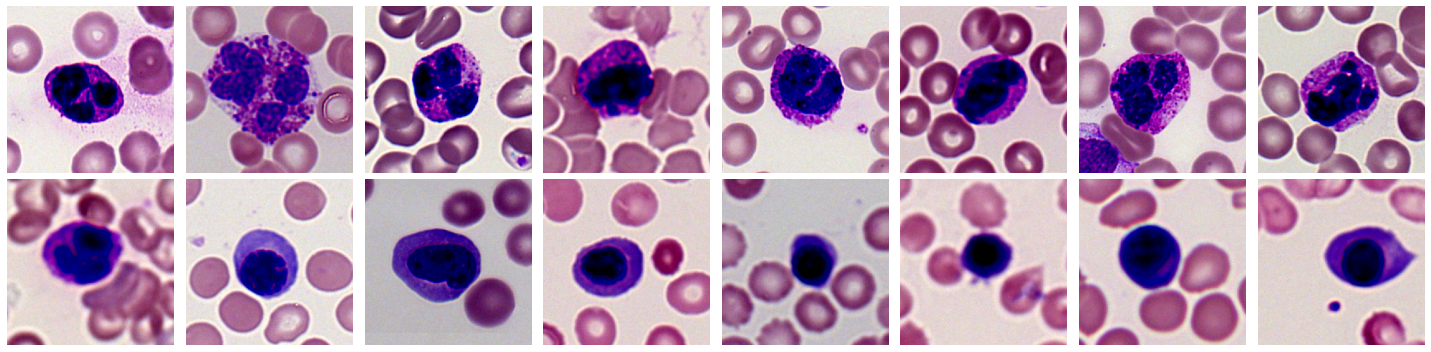

In [15]:
imgs, labels = next(test_generator)
plotImages(imgs)
print(labels)

## **Load From Checkpoint**

In [16]:
#Import Xception model from keras
model = tf.keras.applications.Xception(
    include_top=True,
    weights= None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=15,
    classifier_activation="softmax",
)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [17]:
#implement model.compile
model.compile(loss='categorical_crossentropy',
              optimizer= Adam(learning_rate = 0.0001),
              metrics=['accuracy'])

In [18]:
model.load_weights('/content/gdrive/MyDrive/saved_models/100_epochs_xception_size_299/weights-improvement-39-0.96.hdf5')

## **Predict and Evaluate**

In [19]:
predictions = model.predict(x = test_generator, verbose = 0)

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(test_generator.classes, 
    np.argmax(predictions, axis = -1))

0.9605405405405405

In [21]:
#all cell types/labels for test set
test_generator.classes

array([ 0,  0,  0, ..., 14, 14, 14], dtype=int32)

In [22]:
#create fucntion to map number labels to word labels
val_dic = test_generator.class_indices
inv_val_dic = inv_map = {v: k for k, v in val_dic.items()}

def map_to_labels(array):
  labeled_array = []
  for integer in array:
    labeled_array.append(inv_val_dic[integer])
  return labeled_array

In [23]:
#get the confusion matrix
cm = confusion_matrix(y_true = test_generator.classes, y_pred = np.argmax(predictions, axis = -1))

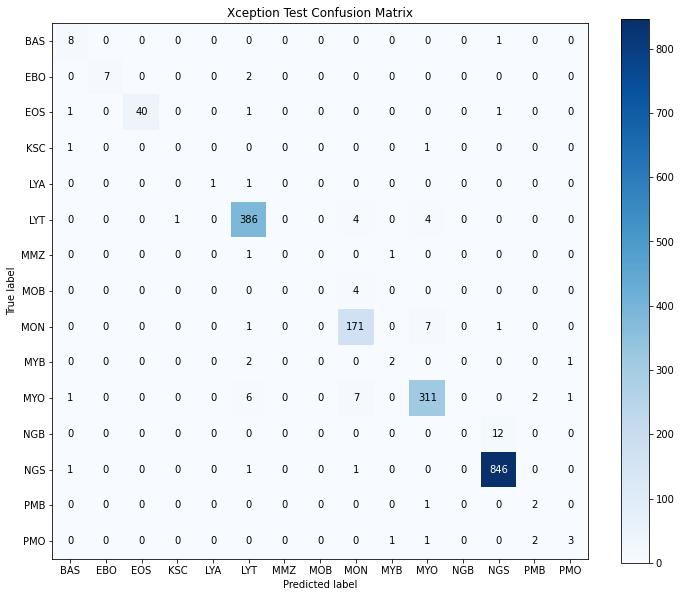

In [24]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    map_to_labels(test_generator.classes), 
    map_to_labels(np.argmax(predictions, axis = -1)),
    title = "Xception Test Confusion Matrix",
    figsize=(12,10))

In [25]:
from sklearn.metrics import classification_report

target_names = ['BAS','EBO','EOS','KSC','LYA','LYT','MMZ','MOB','MON','MYB','MYO','NGB','NGS','PMB','PMO']
print(classification_report(test_generator.classes, np.argmax(predictions, axis = -1), target_names = target_names))

              precision    recall  f1-score   support

         BAS       0.67      0.89      0.76         9
         EBO       1.00      0.78      0.88         9
         EOS       1.00      0.93      0.96        43
         KSC       0.00      0.00      0.00         2
         LYA       1.00      0.50      0.67         2
         LYT       0.96      0.98      0.97       395
         MMZ       0.00      0.00      0.00         2
         MOB       0.00      0.00      0.00         4
         MON       0.91      0.95      0.93       180
         MYB       0.50      0.40      0.44         5
         MYO       0.96      0.95      0.95       328
         NGB       0.00      0.00      0.00        12
         NGS       0.98      1.00      0.99       849
         PMB       0.33      0.67      0.44         3
         PMO       0.60      0.43      0.50         7

    accuracy                           0.96      1850
   macro avg       0.59      0.56      0.57      1850
weighted avg       0.95   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

# **HEATMAP IMPLEMENTATION**
Shown on validation set images

In [27]:
import matplotlib.cm as cm

In [28]:
file_list = ['/content/gdrive/MyDrive/210_data/val/EOS/EOS_0037.tiff',
 '/content/gdrive/MyDrive/210_data/val/EBO/EBO_0052.tiff',
 '/content/gdrive/MyDrive/210_data/val/LYT/LYT_2635.tiff',
 '/content/gdrive/MyDrive/210_data/val/MYB/MYB_0025.tiff',
 '/content/gdrive/MyDrive/210_data/val/PMB/PMB_0013.tiff',
 '/content/gdrive/MyDrive/210_data/val/BAS/BAS_0014.tiff',
 '/content/gdrive/MyDrive/210_data/val/MOB/MOB_0022.tiff',
 '/content/gdrive/MyDrive/210_data/val/LYA/LYA_0006.tiff',
 '/content/gdrive/MyDrive/210_data/val/NGS/NGS_3112.tiff',
 '/content/gdrive/MyDrive/210_data/val/MMZ/MMZ_0012.tiff',
 '/content/gdrive/MyDrive/210_data/val/MYO/MYO_3174.tiff',
 '/content/gdrive/MyDrive/210_data/val/PMO/PMO_0049.tiff',
 '/content/gdrive/MyDrive/210_data/val/MON/MON_1119.tiff',
 '/content/gdrive/MyDrive/210_data/val/NGB/NGB_0040.tiff',
 '/content/gdrive/MyDrive/210_data/val/KSC/KSC_0012.tiff']

In [29]:
def plotImages(images_arr):
  fig, axes = plt.subplots(3,5, figsize = (20,5))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

In [30]:
img_size = (299,299)
preprocess_input = keras.applications.xception.preprocess_input
#decode_predictions = keras.applications.resnet50.decode_predictions

last_conv_layer_name = "conv2d_3"
#last_conv_layer_name = "conv2d_11"

In [31]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [32]:
def make_gradcam(img_path, model, last_conv_layer_name, cam_path='', alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    # Prepare image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

In [33]:
# Remove last layer's softmax
model.layers[-1].activation = None

In [34]:
#Makes heatmaps and saves them to superimposed_images folder
for img_path in file_list:
  cell_type = img_path.split("/")[-1][:3]
  make_gradcam(img_path, model, last_conv_layer_name,cam_path='/content/gdrive/MyDrive/superimposed_images/' + cell_type + ".tiff" , alpha=0.7)

In [35]:
def plot_impose_Images(image_paths):
  fig, axes = plt.subplots(3,5, figsize = (10,5))
  axes = axes.flatten()
  for image_path, ax in zip(image_paths, axes):
    cell_type = image_path.split("/")[-1][:3]
    img = Image.open(image_path)
    ax.imshow(img)
    ax.title.set_text('Cell Type: ' + cell_type)
    ax.axis('off')
  plt.suptitle('Xception Heatmap', y = 1.05, size = 16)
  plt.tight_layout()
  plt.show()

In [36]:
impose_images_paths = []
for file in os.listdir('/content/gdrive/MyDrive/superimposed_images'):
  impose_images_paths.append(os.path.join('/content/gdrive/MyDrive/superimposed_images',file))
impose_images_paths

['/content/gdrive/MyDrive/superimposed_images/EOS.tiff',
 '/content/gdrive/MyDrive/superimposed_images/EBO.tiff',
 '/content/gdrive/MyDrive/superimposed_images/LYT.tiff',
 '/content/gdrive/MyDrive/superimposed_images/MYB.tiff',
 '/content/gdrive/MyDrive/superimposed_images/PMB.tiff',
 '/content/gdrive/MyDrive/superimposed_images/BAS.tiff',
 '/content/gdrive/MyDrive/superimposed_images/MOB.tiff',
 '/content/gdrive/MyDrive/superimposed_images/LYA.tiff',
 '/content/gdrive/MyDrive/superimposed_images/NGS.tiff',
 '/content/gdrive/MyDrive/superimposed_images/MMZ.tiff',
 '/content/gdrive/MyDrive/superimposed_images/MYO.tiff',
 '/content/gdrive/MyDrive/superimposed_images/PMO.tiff',
 '/content/gdrive/MyDrive/superimposed_images/MON.tiff',
 '/content/gdrive/MyDrive/superimposed_images/NGB.tiff',
 '/content/gdrive/MyDrive/superimposed_images/KSC.tiff']

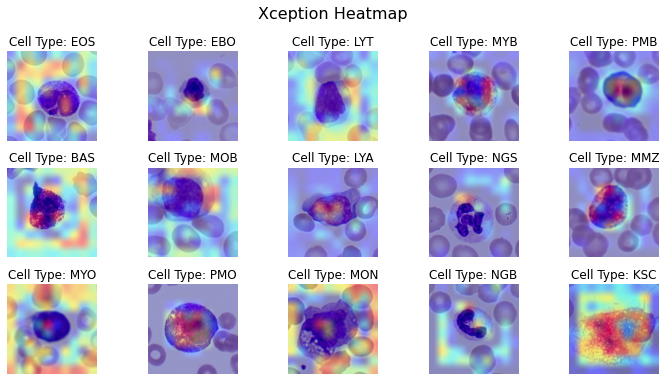

In [37]:
plot_impose_Images(impose_images_paths)

# **Naive Implemenation of Uncertainty Quantification**

In [38]:
#reload model from weights to get back softmax layer

In [39]:
#Import Xception model from keras
model = tf.keras.applications.Xception(
    include_top=True,
    weights= None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=15,
    classifier_activation="softmax",
)

In [40]:
#implement model.compile
model.compile(loss='categorical_crossentropy',
              optimizer= Adam(learning_rate = 0.0001),
              metrics=['accuracy'])

In [41]:
model.load_weights('/content/gdrive/MyDrive/saved_models/100_epochs_xception_size_299/weights-improvement-39-0.96.hdf5')

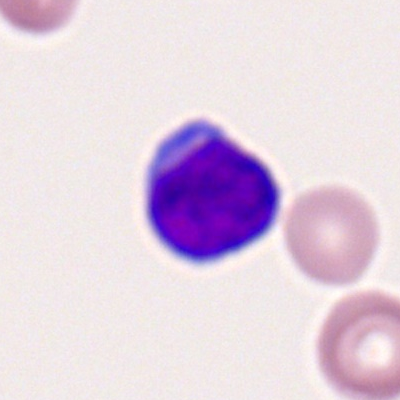

In [42]:
test_img_path = '/content/gdrive/MyDrive/210_data/train/LYT/LYT_3862.tiff'
im = Image.open(test_img_path)
im

In [43]:
arr = preprocess_input(get_img_array(test_img_path, size=img_size))
np.argmax(model.predict(arr), axis = -1)[0]

5

In [44]:
def get_naive_confidence_interval_from_image_path(confidence_interval_decimal, image_path):
  """This function takes an image filepath and a desired confidence interval as arguments and returns a dictionary with the predicted class abbreviations and their probabilities as predicted by the model. This is a naive approach and does not take overconfidence by the model into account"""
  arr = preprocess_input(get_img_array(test_img_path, size=img_size))
  prediction_pcts = list(model.predict(arr)[0])
  full_list = prediction_pcts.copy()
  confidence_interval_array = []
  for i in prediction_pcts:
    top_pred = max(prediction_pcts)
    confidence_interval_array.append(top_pred)
    prediction_pcts.remove(top_pred)
    if sum(confidence_interval_array) >= confidence_interval_decimal:
      break
  if sum(confidence_interval_array) < confidence_interval_decimal:
    print("Not possible to reach confidence interval") 
  else:
    int_answer_list = [full_list.index(i) for i in confidence_interval_array]
    name_answer_list = [inv_val_dic[i] for i in int_answer_list]
    answers = dict(zip(name_answer_list, confidence_interval_array))
    return answers

In [45]:
get_naive_confidence_interval_from_image_path(.9999,test_img_path)

{'LYT': 0.9990988, 'MYO': 0.00088287785}

In [47]:
#next, define a function that instead of image path uses a generator to calculate all confidence intervals
def get_naive_confidence_interval_from_single_image_prediction_probabilities(confidence_interval_decimal, single_image_prediction_array):
    """This function takes a single image prediction probabilties array a desired confidence interval as arguments and returns a dictionary with the predicted class abbreviations and their probabilities as predicted by the model. This is a naive approach and does not take overconfidence by the model into account"""
    prediction_pcts = list(single_image_prediction_array)
    full_list = prediction_pcts.copy()
    confidence_interval_array = []
    for i in prediction_pcts:
      top_pred = max(prediction_pcts)
      confidence_interval_array.append(top_pred)
      prediction_pcts.remove(top_pred)
      if sum(confidence_interval_array) >= confidence_interval_decimal:
        break
    if sum(confidence_interval_array) < confidence_interval_decimal:
      return "Not possible to reach confidence interval" 
    else:
      int_answer_list = [full_list.index(i) for i in confidence_interval_array]
      name_answer_list = [inv_val_dic[i] for i in int_answer_list]
      answers = dict(zip(name_answer_list, confidence_interval_array))
      #sorted_answers = sorted(answers.items(), key=lambda item: item[1], reverse = True)
      #dict_sorted_answers = dict(sorted_answers)
      #sorted_answers = sorted(answers)
      return answers

In [48]:
def naive_confidence_intervals(confidence_interval_decimal, predictions):
    """This function takes a model.predict call and a desired confidence interval as arguments and returns a dictionary with the predicted class abbreviations and their probabilities as predicted by the model. This is a naive approach and does not take overconfidence by the model into account"""
    confidence_intervals = []
    for i in predictions:
      confidence_intervals.append(get_naive_confidence_interval_from_single_image_prediction_probabilities(confidence_interval_decimal, i))
    return confidence_intervals


In [53]:
#This cell outputs the predicted cell classes with given model probability 
naive_confidence_intervals(.999, predictions)

[{'BAS': 0.99718237, 'NGS': 0.002028354},
 {'BAS': 0.0038490428,
  'EOS': 0.004165675,
  'MMZ': 0.001633409,
  'NGB': 0.00073008257,
  'NGS': 0.9891573},
 {'BAS': 0.5009424, 'EOS': 0.09524848, 'NGS': 0.40302613},
 {'BAS': 0.9962528, 'EOS': 0.0012996553, 'NGS': 0.0023723915},
 {'BAS': 0.9964139, 'EOS': 0.0034425897},
 {'BAS': 0.9927516, 'EOS': 0.0016005337, 'NGS': 0.004800635},
 {'BAS': 0.99911076},
 {'BAS': 0.8114499, 'NGS': 0.18787271},
 {'BAS': 0.72488785,
  'LYT': 0.008955217,
  'MMZ': 0.004745584,
  'MYB': 0.003523716,
  'NGB': 0.0046111993,
  'NGS': 0.252816},
 {'EBO': 0.9856565, 'LYT': 0.014225936},
 {'EBO': 0.932192, 'LYT': 0.06596027, 'MON': 0.0011293205},
 {'EBO': 0.9968925, 'LYT': 0.0030405587},
 {'EBO': 0.7637232, 'LYT': 0.23484384, 'NGS': 0.0012304139},
 {'EBO': 0.9868238, 'LYT': 0.012921549},
 {'LYT': 0.99981624},
 {'EBO': 0.012623831, 'LYT': 0.98680043},
 {'EBO': 0.98789155, 'LYT': 0.008487831, 'NGS': 0.0035728253},
 {'EBO': 0.95251095, 'LYT': 0.034917843, 'NGS': 0.012431